In [1]:
import os 
import time

import torch 
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

import matplotlib.pyplot as plt
import numpy as np

using device cuda:0


In [2]:
path = !pwd
path = path[0]
print(path)
save_filename = path+"/models/resnet56_cumultrain_parameters.pickle"
load_filename = save_filename

/home/r2/Documents/DD2424project


### Functions 

In [3]:
def show_model(model):
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())
def make_oneh(labels):
    oneh_labels = np.zeros([labels.shape[0], 10])
    indexes = np.array([np.arange(0,labels.shape[0]), labels.numpy()])
    oneh_labels[tuple(indexes)] = 1.0
    return torch.tensor(oneh_labels).long()
def get_xent_acc(prediction, labels):
    predicted_labels = np.argmax(prediction.cpu().data.numpy(),1)
    (predicted_labels - labels.cpu().data.numpy())
    return sum((predicted_labels - labels.cpu().data.numpy()) == 0)/predicted_labels.shape[0]
def xent_softmax(prediction):
    pred = np.exp(prediction.cpu().data.numpy())
    divide = np.repeat(pred.sum(1).reshape(pred.shape[0],1), pred.shape[1],1)
    pred = np.divide(pred,divide)
    return pred 
def get_valacc(valid_data_loader, valacc):
    val_iterator = iter(valid_data_loader)
    valimgs, vallabels = val_iterator.next()            
    f"""resnet.eval() should make forwardpass not(!) save activations"""
    resnet.eval()  
    if cuda_available: 
        valimgs   = valimgs.cuda()
        vallabels = vallabels.cuda()
    valacc = valacc + [get_xent_acc(resnet.forward(valimgs), vallabels)]
    f"""resnet.train() should make forwardpass save activations again"""
    resnet.train()
    return valacc

### setup data

In [4]:
torchvision.datasets.CIFAR10(path,download=True)

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: /home/r2/Documents/DD2424project
    Transforms (if any): None
    Target Transforms (if any): None

In [5]:
f"""adding transform ToTensor(); transforms PIL-images to tensor-format used by PyTorch""" 
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
cifar10_train = torchvision.datasets.CIFAR10(path, train=True, transform=transform)
cifar10_valid = torchvision.datasets.CIFAR10(path, train=False,transform=transform)
train_data_loader = torch.utils.data.DataLoader(cifar10_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)
valid_data_loader = torch.utils.data.DataLoader(cifar10_valid,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)

### ResNet-56
#### https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py

In [6]:

def _weights_init(m):
    classname = m.__class__.__name__
    print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



In [7]:
%%capture
f"""To get ResNet56 use ResNet(BasicBlock,[9,9,9])""" 
resnet = ResNet(BasicBlock,[9,9,9])
if cuda_available: 
    resnet.cuda()

### create loss function 
#### https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7

In [8]:
loss_xent = nn.CrossEntropyLoss()
loss_mse  = nn.MSELoss()

### add pytorch-optimizer to use custom update-rules
### https://pytorch.org/docs/stable/optim.html

#### Cyclical learner schedule built into pytorch: 
#### torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=2000, step_size_down=None, mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9, last_epoch=-1)

In [9]:
optimizer = optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

### play with forward and backwards pass

In [12]:
start    = time.time()
f"""load previous model"""
# if os.path.isfile(load_filename):
#     resnet.load_state_dict(torch.load(load_filename))
n_epoch  = 4
validation_interval = 10

# trainacc = [] 
# valacc   = [] 
# loss     = []

for epoch in range(n_epoch):
    train_iterator = iter(train_data_loader)
    for i in range(len(train_iterator)):
        images, labels = train_iterator.next()
        
        f"""if we use GPU, input- and target-tensors must be loaded on GPU as well."""
        if cuda_available: 
            images = images.cuda()
            labels = labels.cuda()
            
        prediction = resnet.forward(images)
        output     = loss_xent(prediction, labels)
        
        trainacc = trainacc + [get_xent_acc(prediction, labels)]
        loss     = loss + [output]
        
        f"""using zero_grad() seems to be necessary. step() does not clear the gradients"""
        optimizer.zero_grad()
        output.backward() # calculates gradients 
        optimizer.step()  # updates weights
        
        if i % validation_interval == 0:
            valacc = get_valacc(valid_data_loader, valacc)
            
    print(f"""time passed after training {epoch+1} epochs is {time.time()-start} seconds""")

time passed after training 1 epochs is 30.059319496154785 seconds
time passed after training 2 epochs is 60.08831763267517 seconds
time passed after training 3 epochs is 90.12345790863037 seconds
time passed after training 4 epochs is 120.14941430091858 seconds


### Plot results 

In [19]:
x1, x2, x3 = [np.linspace(0, len(trainacc), num) for num in [len(loss), len(trainacc), len(valacc)]]

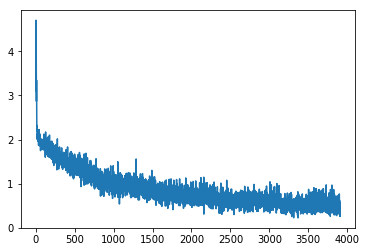

In [20]:
plt.plot(x1,np.array(loss))
plt.show()

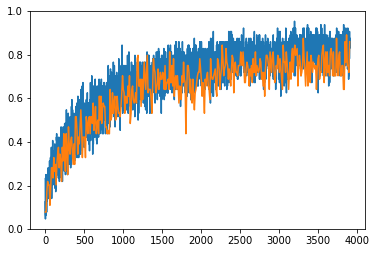

In [21]:
plt.plot(x2,np.array(trainacc))
plt.plot(x3,np.array(valacc))
plt.show()

### Save/Load Model
### https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [ ]:
%%capture 
f"""save"""
torch.save(resnet.state_dict(), save_filename)
f"""load"""
resnet2 = ResNet(BasicBlock,[9,9,9])
resnet2.load_state_dict(torch.load(load_filename))

In [ ]:
f"""compare saved and loaded models parameters""" 
net1_param, net2_param, diff = [], [], 0
for param_tensor in resnet.state_dict():
    net1_param = net1_param + [resnet.state_dict()[param_tensor]]
    net2_param = net2_param + [resnet2.state_dict()[param_tensor]]
for i in range(len(net1_param)):
    diff = diff + np.sum(net1_param[i].cpu().numpy() - net2_param[i].cpu().numpy())
print(f"""difference in weights and biases is: {diff} between the saved and the loaded network""")

#### DenseNet

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
imshow(torchvision.utils.make_grid(images.cpu()))

In [ ]:
densenet = models.densenet161()